## Transfer Learning mobilenetV2 using Tensorflow

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Nov  1 12:50:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

train_path = '/content/drive/MyDrive/dataset/brain tumor multiclass/train'
valid_path = '/content/drive/MyDrive/dataset/brain tumor multiclass/val'
test_path = '/content/drive/MyDrive/dataset/brain tumor multiclass/test'

In [5]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/dataset/brain tumor multiclass/train/*')
folders

['/content/drive/MyDrive/dataset/brain tumor multiclass/train/brain_tumor_glioma',
 '/content/drive/MyDrive/dataset/brain tumor multiclass/train/brain_tumor_meningioma',
 '/content/drive/MyDrive/dataset/brain tumor multiclass/train/brain_tumor_notumor',
 '/content/drive/MyDrive/dataset/brain tumor multiclass/train/brain_tumor_pituitary']

In [6]:
import os
for folder in folders:
  name = folder.split("/")[-1]
  print(f"{name} folder has {len(os.listdir(folder))} samples")

brain_tumor_glioma folder has 1134 samples
brain_tumor_meningioma folder has 1151 samples
brain_tumor_notumor folder has 1400 samples
brain_tumor_pituitary folder has 1229 samples


In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4914 images belonging to 4 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 1404 images belonging to 4 classes.


In [9]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 705 images belonging to 4 classes.


### Model

In [10]:
engine = tf.keras.applications.MobileNetV2(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(len(folders), activation = 'softmax', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stopping, reduce_lr,learning_rate_reduction]
)

Epoch 1/20
154/154 [==============================] - 1334s 9s/step - loss: 0.4378 - accuracy: 0.8498 - val_loss: 2.0053 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 2/20
154/154 [==============================] - 79s 511ms/step - loss: 0.2456 - accuracy: 0.9204 - val_loss: 6.0536 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 3/20
154/154 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9249
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
154/154 [==============================] - 79s 510ms/step - loss: 0.2336 - accuracy: 0.9249 - val_loss: 7.1238 - val_accuracy: 0.4729 - lr: 0.0010
Epoch 4/20
154/154 [==============================] - 78s 505ms/step - loss: 0.1148 - accuracy: 0.9646 - val_loss: 7.5215 - val_accuracy: 0.3583 - lr: 2.5000e-04
Epoch 5/20
154/154 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9683
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
154/154 [=======================

In [16]:
import matplotlib.pyplot as plt

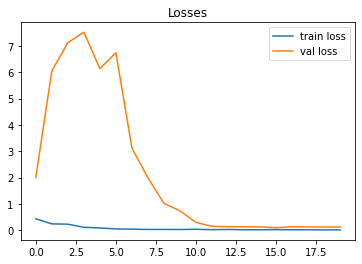

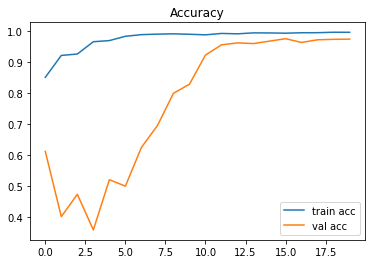

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [18]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9744200259447098

In [19]:
# val accuracy
model.evaluate(val_set)

44/44 [==============================] - 6s 135ms/step - loss: 0.1239 - accuracy: 0.9729


[0.12386326491832733, 0.9729344844818115]

In [20]:
# test accuracy
model.evaluate(test_set)

23/23 [==============================] - 183s 8s/step - loss: 0.0948 - accuracy: 0.9716


[0.09475083649158478, 0.9716312289237976]

In [21]:
test_set.class_indices

{'brain_tumor_glioma': 0,
 'brain_tumor_meningioma': 1,
 'brain_tumor_notumor': 2,
 'brain_tumor_pituitary': 3}

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
print(prob)

23/23 [==============================] - 6s 198ms/step
[[9.9653339e-01 1.0898594e-03 2.2321565e-03 1.4463042e-04]
 [9.9956530e-01 4.2537932e-04 4.3997688e-06 4.8728043e-06]
 [9.9958664e-01 4.0074892e-04 1.0680534e-05 1.9007226e-06]
 ...
 [1.4793485e-06 1.1889097e-08 3.2086898e-09 9.9999845e-01]
 [3.4898806e-06 5.9602723e-08 1.8810664e-06 9.9999452e-01]
 [1.4353538e-05 3.2473679e-06 6.2042068e-06 9.9997616e-01]]


In [23]:
predIdxs = np.argmax(prob, axis=1) 

print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['glioma','meningioma','notumor','pituitary'], digits=5))



              precision    recall  f1-score   support

      glioma    0.98765   0.98160   0.98462       163
  meningioma    0.98077   0.92727   0.95327       165
     notumor    1.00000   0.97500   0.98734       200
   pituitary    0.92188   1.00000   0.95935       177

    accuracy                        0.97163       705
   macro avg    0.97257   0.97097   0.97114       705
weighted avg    0.97303   0.97163   0.97171       705



In [24]:

y_true = test_set.labels
y_pred = predIdxs
cm=confusion_matrix(y_true,y_pred)
cm

array([[160,   1,   0,   2],
       [  2, 153,   0,  10],
       [  0,   2, 195,   3],
       [  0,   0,   0, 177]])

Text(69.0, 0.5, 'Predicted Values')

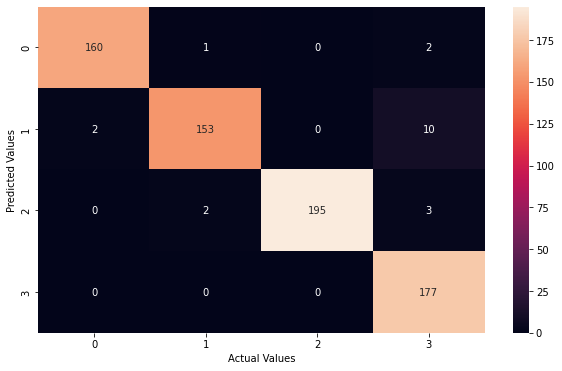

In [25]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [26]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

0.9716312056737588 0.9716312056737588 0.9716312056737588 0.9709669548243168 0.962515807880197


In [27]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('Transfer_Learning_brain_multiclass_mobilenetV2.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('/content/lung cancer_mobilenetV2.h5')

In [ ]:
img=image.load_img('/content/drive/MyDrive/Lung Cancer/test/Lung squamous/lungscc1000.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x.shape

(224, 224, 3)

In [ ]:
# # from keras.applications.xception import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.shape

In [ ]:
img_data = x.reshape(1,224,224,3)

In [ ]:
result = model.predict(img_data)
result = np.argmax(result, axis=-1)
result

1/1 [==============================] - 1s 972ms/step


array([2])

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)
a

1/1 [==============================] - 0s 19ms/step


array([2])